# Ultrasound Reconstruction with IMU and Optical Tracker Data


## 1. Import Libraries


In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import RegularGridInterpolator
from scipy.spatial.transform import Rotation
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from tqdm.notebook import tqdm

## 2. Load and Preprocess Data


In [2]:
def load_data(file_path):
    return pd.read_hdf(file_path)


file_path = "/home/varun/xia_lab/repos/ABUSFusion/scans/20240826/wrist_data.h5"
df = load_data(file_path)

## 3. Create Dataset and DataLoader


In [3]:
class UltrasoundSequenceDataset(Dataset):
    def __init__(self, df, sequence_length=2, transform=None, downsample_factor=3):
        self.df = df
        self.sequence_length = sequence_length
        self.transform = transform
        self.downsample_factor = downsample_factor

        # Create a resizing transform
        self.resize = transforms.Resize(
            (1000 // self.downsample_factor, 657 // self.downsample_factor)
        )

    def __len__(self):
        return len(self.df) - self.sequence_length + 1

    def __getitem__(self, idx):
        sequence = self.df.iloc[idx : idx + self.sequence_length]

        frames = torch.tensor(np.stack(sequence["frame"].values)).float()
        frames = frames.mean(dim=-1, keepdim=True)  # Convert RGB to grayscale
        frames = frames.permute(
            0, 3, 1, 2
        )  # Change to (sequence_length, channels, height, width)

        # Apply resizing to each frame in the sequence
        resized_frames = torch.stack([self.resize(frame) for frame in frames])

        imu_data = torch.tensor(
            sequence[
                [
                    "imu_acc_x",
                    "imu_acc_y",
                    "imu_acc_z",
                    "imu_orientation_x",
                    "imu_orientation_y",
                    "imu_orientation_z",
                ]
            ].values
        ).float()

        ot_data = torch.tensor(
            sequence[
                ["ot_pos_x", "ot_pos_y", "ot_pos_z", "ot_qw", "ot_qx", "ot_qy", "ot_qz"]
            ].values
        ).float()

        sample = (resized_frames, imu_data, ot_data)

        if self.transform:
            sample = self.transform(sample)

        return sample

In [4]:
class QuaternionToEulerTransform:
    def __call__(self, sample):
        frames, imu_data, ot_data = sample

        ot_pos = ot_data[..., :3]
        ot_quat = ot_data[..., 3:]

        # Convert quaternions to Euler angles
        ot_euler = torch.tensor(
            Rotation.from_quat(ot_quat.numpy()).as_euler("xyz")
        ).float()
        target = torch.cat([ot_pos, ot_euler], dim=-1)

        return frames, imu_data, target

In [5]:
# Create datasets and dataloaders
transform = QuaternionToEulerTransform()
dataset = UltrasoundSequenceDataset(
    df, sequence_length=2, transform=transform, downsample_factor=3
)

In [6]:
# Split the dataset
train_indices, val_indices = train_test_split(
    range(len(dataset)), test_size=0.2, random_state=42
)

In [7]:
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

In [8]:
train_loader = DataLoader(dataset, batch_size=8, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=1, sampler=val_sampler)

## 4. Define Model Architecture


In [9]:
class UltrasoundIMUModel(nn.Module):
    def __init__(self, input_channels=1, input_height=1000, input_width=657):
        super(UltrasoundIMUModel, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        conv_output_height = input_height // 4
        conv_output_width = input_width // 4

        self.lstm = nn.LSTM(
            64 * conv_output_height * conv_output_width + 6, 128, batch_first=True
        )
        self.fc = nn.Linear(128, 6)  # Output: tx, ty, tz, rx, ry, rz

    def forward(self, frames, imu_data):
        batch_size, seq_len, _, height, width = frames.shape

        frame_features = []
        for i in range(seq_len):
            x = self.pool(torch.relu(self.conv1(frames[:, i, :, :, :])))
            x = self.pool(torch.relu(self.conv2(x)))
            frame_features.append(x.view(batch_size, -1))

        combined_features = torch.cat(
            [torch.stack(frame_features, dim=1), imu_data], dim=2
        )

        lstm_out, _ = self.lstm(combined_features)
        transformations = self.fc(lstm_out[:, -1, :])  # Use only the last output

        return transformations

In [10]:
# Initialize model
model = UltrasoundIMUModel(
    input_channels=1, input_height=1000 // 3, input_width=657 // 3
)

## 5. Train Model


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.SmoothL1Loss(beta=4.0)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=5, verbose=True
)

/home/varun/mambaforge/envs/abusfusion/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [12]:
def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    num_epochs=10000,
    patience=10,
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    best_val_loss = float("inf")
    best_model_weights = None
    epochs_no_improve = 0

    for epoch in tqdm(range(num_epochs), desc="Epochs", position=0):
        model.train()
        train_loss = 0.0
        epoch_progress = tqdm(
            train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", position=1, leave=False
        )
        for frames, imu_data, targets in epoch_progress:
            frames, imu_data, targets = (
                frames.to(device),
                imu_data.to(device),
                targets.to(device),
            )

            optimizer.zero_grad()
            outputs = model(frames, imu_data)
            loss = criterion(
                outputs, targets[:, -1, :]
            )  # Compare with the last target in the sequence
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_loss_avg = train_loss / (epoch_progress.n + 1)

            epoch_progress.set_postfix({"Avg Loss": f"{train_loss_avg:.4f}"})

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for frames, imu_data, targets in val_loader:
                frames, imu_data, targets = (
                    frames.to(device),
                    imu_data.to(device),
                    targets.to(device),
                )
                outputs = model(frames, imu_data)
                loss = criterion(outputs, targets[:, -1, :])
                val_loss += loss.item()

        val_loss /= len(val_loader)

        scheduler.step(val_loss)

        tqdm.write(
            f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss_avg:.4f}, Val Loss: {val_loss:.4f}"
        )

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict().copy()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                tqdm.write("Early stopping triggered")
                break

    model.load_state_dict(best_model_weights)
    return model

In [13]:
# Train the model
trained_model = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler
)

# Save the best model
torch.save(trained_model.state_dict(), "best_model.pth")

Epochs:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 1/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/10000, Train Loss: 175.2594, Val Loss: 168.9464


Epoch 2/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/10000, Train Loss: 167.3405, Val Loss: 159.0063


Epoch 3/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/10000, Train Loss: 157.6009, Val Loss: 149.8178


Epoch 4/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/10000, Train Loss: 147.5859, Val Loss: 139.7190


Epoch 5/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/10000, Train Loss: 139.8585, Val Loss: 134.2349


Epoch 6/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/10000, Train Loss: 134.3062, Val Loss: 128.8641


Epoch 7/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/10000, Train Loss: 128.6626, Val Loss: 123.3723


Epoch 8/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/10000, Train Loss: 123.3176, Val Loss: 118.7047


Epoch 9/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/10000, Train Loss: 118.5345, Val Loss: 113.4391


Epoch 10/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/10000, Train Loss: 112.9984, Val Loss: 108.0306


Epoch 11/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 11/10000, Train Loss: 107.6594, Val Loss: 102.5408


Epoch 12/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 12/10000, Train Loss: 102.1472, Val Loss: 97.5096


Epoch 13/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 13/10000, Train Loss: 97.0465, Val Loss: 92.5140


Epoch 14/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 14/10000, Train Loss: 91.9860, Val Loss: 87.6073


Epoch 15/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 15/10000, Train Loss: 87.0031, Val Loss: 82.7421


Epoch 16/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 16/10000, Train Loss: 82.0630, Val Loss: 77.9233


Epoch 17/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 17/10000, Train Loss: 77.1653, Val Loss: 73.1425


Epoch 18/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 18/10000, Train Loss: 72.3062, Val Loss: 68.3958


Epoch 19/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 19/10000, Train Loss: 67.4847, Val Loss: 63.6841


Epoch 20/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 20/10000, Train Loss: 62.6910, Val Loss: 59.0056


Epoch 21/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 21/10000, Train Loss: 57.9359, Val Loss: 54.3578


Epoch 22/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 22/10000, Train Loss: 53.2022, Val Loss: 49.7383


Epoch 23/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 23/10000, Train Loss: 48.5121, Val Loss: 45.1573


Epoch 24/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 24/10000, Train Loss: 42.9718, Val Loss: 40.5923


Epoch 25/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 25/10000, Train Loss: 38.4279, Val Loss: 36.0623


Epoch 26/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 26/10000, Train Loss: 34.5950, Val Loss: 31.5712


Epoch 27/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 27/10000, Train Loss: 30.0273, Val Loss: 27.0909


Epoch 28/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 28/10000, Train Loss: 25.4676, Val Loss: 22.6218


Epoch 29/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 29/10000, Train Loss: 20.9282, Val Loss: 18.2042


Epoch 30/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 30/10000, Train Loss: 16.4278, Val Loss: 13.7959


Epoch 31/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 31/10000, Train Loss: 11.9500, Val Loss: 9.4193


Epoch 32/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 32/10000, Train Loss: 7.5107, Val Loss: 5.1748


Epoch 33/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 33/10000, Train Loss: 4.0425, Val Loss: 3.3580


Epoch 34/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 34/10000, Train Loss: 2.8084, Val Loss: 2.9018


Epoch 35/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 35/10000, Train Loss: 2.5810, Val Loss: 2.8283


Epoch 36/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 36/10000, Train Loss: 2.5255, Val Loss: 2.8128


Epoch 37/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 37/10000, Train Loss: 2.5352, Val Loss: 2.8355


Epoch 38/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 38/10000, Train Loss: 2.5102, Val Loss: 2.8114


Epoch 39/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 39/10000, Train Loss: 2.5827, Val Loss: 2.8132


Epoch 40/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 40/10000, Train Loss: 2.5113, Val Loss: 2.7905


Epoch 41/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 41/10000, Train Loss: 2.5577, Val Loss: 2.8169


Epoch 42/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 42/10000, Train Loss: 2.5708, Val Loss: 2.7966


Epoch 43/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 43/10000, Train Loss: 2.5673, Val Loss: 2.7920


Epoch 44/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 44/10000, Train Loss: 2.4968, Val Loss: 2.7894


Epoch 45/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 45/10000, Train Loss: 2.5594, Val Loss: 2.7942


Epoch 46/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 46/10000, Train Loss: 2.5556, Val Loss: 2.8033


Epoch 47/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 47/10000, Train Loss: 2.5753, Val Loss: 2.8021


Epoch 48/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 48/10000, Train Loss: 2.5486, Val Loss: 2.7859


Epoch 49/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 49/10000, Train Loss: 2.5400, Val Loss: 2.7929


Epoch 50/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 50/10000, Train Loss: 2.5728, Val Loss: 2.8129


Epoch 51/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 51/10000, Train Loss: 2.5522, Val Loss: 2.7841


Epoch 52/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 52/10000, Train Loss: 2.5565, Val Loss: 2.7908


Epoch 53/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 53/10000, Train Loss: 2.4998, Val Loss: 2.7976


Epoch 54/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 54/10000, Train Loss: 2.5549, Val Loss: 2.7840


Epoch 55/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 55/10000, Train Loss: 2.5524, Val Loss: 2.7849


Epoch 56/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 56/10000, Train Loss: 2.5382, Val Loss: 2.7968


Epoch 57/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 57/10000, Train Loss: 2.5684, Val Loss: 2.8199


Epoch 58/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 58/10000, Train Loss: 2.5573, Val Loss: 2.7913


Epoch 59/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 59/10000, Train Loss: 2.5472, Val Loss: 2.7911


Epoch 60/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 60/10000, Train Loss: 2.5428, Val Loss: 2.7868


Epoch 61/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 61/10000, Train Loss: 2.5439, Val Loss: 2.7882


Epoch 62/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 62/10000, Train Loss: 2.5386, Val Loss: 2.7822


Epoch 63/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 63/10000, Train Loss: 2.5376, Val Loss: 2.7836


Epoch 64/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 64/10000, Train Loss: 2.5369, Val Loss: 2.7812


Epoch 65/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 65/10000, Train Loss: 2.5346, Val Loss: 2.7793


Epoch 66/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 66/10000, Train Loss: 2.5374, Val Loss: 2.7839


Epoch 67/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 67/10000, Train Loss: 2.5352, Val Loss: 2.7788


Epoch 68/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 68/10000, Train Loss: 2.5323, Val Loss: 2.7791


Epoch 69/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 69/10000, Train Loss: 2.5335, Val Loss: 2.7761


Epoch 70/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 70/10000, Train Loss: 2.4848, Val Loss: 2.7782


Epoch 71/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 71/10000, Train Loss: 2.4812, Val Loss: 2.7766


Epoch 72/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 72/10000, Train Loss: 2.4821, Val Loss: 2.7764


Epoch 73/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 73/10000, Train Loss: 2.4801, Val Loss: 2.7774


Epoch 74/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 74/10000, Train Loss: 2.5291, Val Loss: 2.7743


Epoch 75/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 75/10000, Train Loss: 2.5308, Val Loss: 2.7777


Epoch 76/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 76/10000, Train Loss: 2.5324, Val Loss: 2.7748


Epoch 77/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 77/10000, Train Loss: 2.5316, Val Loss: 2.7756


Epoch 78/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 78/10000, Train Loss: 2.5303, Val Loss: 2.7753


Epoch 79/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 79/10000, Train Loss: 2.5269, Val Loss: 2.7717


Epoch 80/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 80/10000, Train Loss: 2.5282, Val Loss: 2.7735


Epoch 81/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 81/10000, Train Loss: 2.5272, Val Loss: 2.7731


Epoch 82/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 82/10000, Train Loss: 2.5308, Val Loss: 2.7716


Epoch 83/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 83/10000, Train Loss: 2.5290, Val Loss: 2.7727


Epoch 84/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 84/10000, Train Loss: 2.5303, Val Loss: 2.7751


Epoch 85/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 85/10000, Train Loss: 2.4759, Val Loss: 2.7732


Epoch 86/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 86/10000, Train Loss: 2.5221, Val Loss: 2.7730


Epoch 87/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 87/10000, Train Loss: 2.5250, Val Loss: 2.7727


Epoch 88/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 88/10000, Train Loss: 2.5254, Val Loss: 2.7723


Epoch 89/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 89/10000, Train Loss: 2.5250, Val Loss: 2.7725


Epoch 90/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 90/10000, Train Loss: 2.4737, Val Loss: 2.7722


Epoch 91/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 91/10000, Train Loss: 2.5275, Val Loss: 2.7723


Epoch 92/10000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 92/10000, Train Loss: 2.5241, Val Loss: 2.7723
Early stopping triggered


## 6. Evaluate Model


In [14]:
def evaluate_model(model, data_loader):
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for frames, imu_data, targets in data_loader:
            frames, imu_data, targets = (
                frames.to(device),
                imu_data.to(device),
                targets.to(device),
            )
            outputs = model(frames, imu_data)
            loss = criterion(outputs, targets[:, -1, :])
            total_loss += loss.item()

            all_predictions.append(outputs.cpu().numpy())
            all_targets.append(targets[:, -1, :].cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    all_predictions = np.concatenate(all_predictions)
    all_targets = np.concatenate(all_targets)

    return avg_loss, all_predictions, all_targets

In [15]:
# Evaluate the model
val_loss, val_predictions, val_targets = evaluate_model(trained_model, val_loader)
print(f"Validation Loss: {val_loss:.4f}")

Validation Loss: 2.7723


## 7. Visualize Results


In [16]:
def visualize_predictions(predictions, targets):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    titles = [
        "Translation X",
        "Translation Y",
        "Translation Z",
        "Rotation X",
        "Rotation Y",
        "Rotation Z",
    ]

    for i in range(6):
        ax = axes[i // 3, i % 3]
        ax.plot(predictions[:100, i], label="Predicted")
        ax.plot(targets[:100, i], label="Ground Truth")
        ax.set_title(titles[i])
        ax.legend()

    plt.tight_layout()
    plt.show()

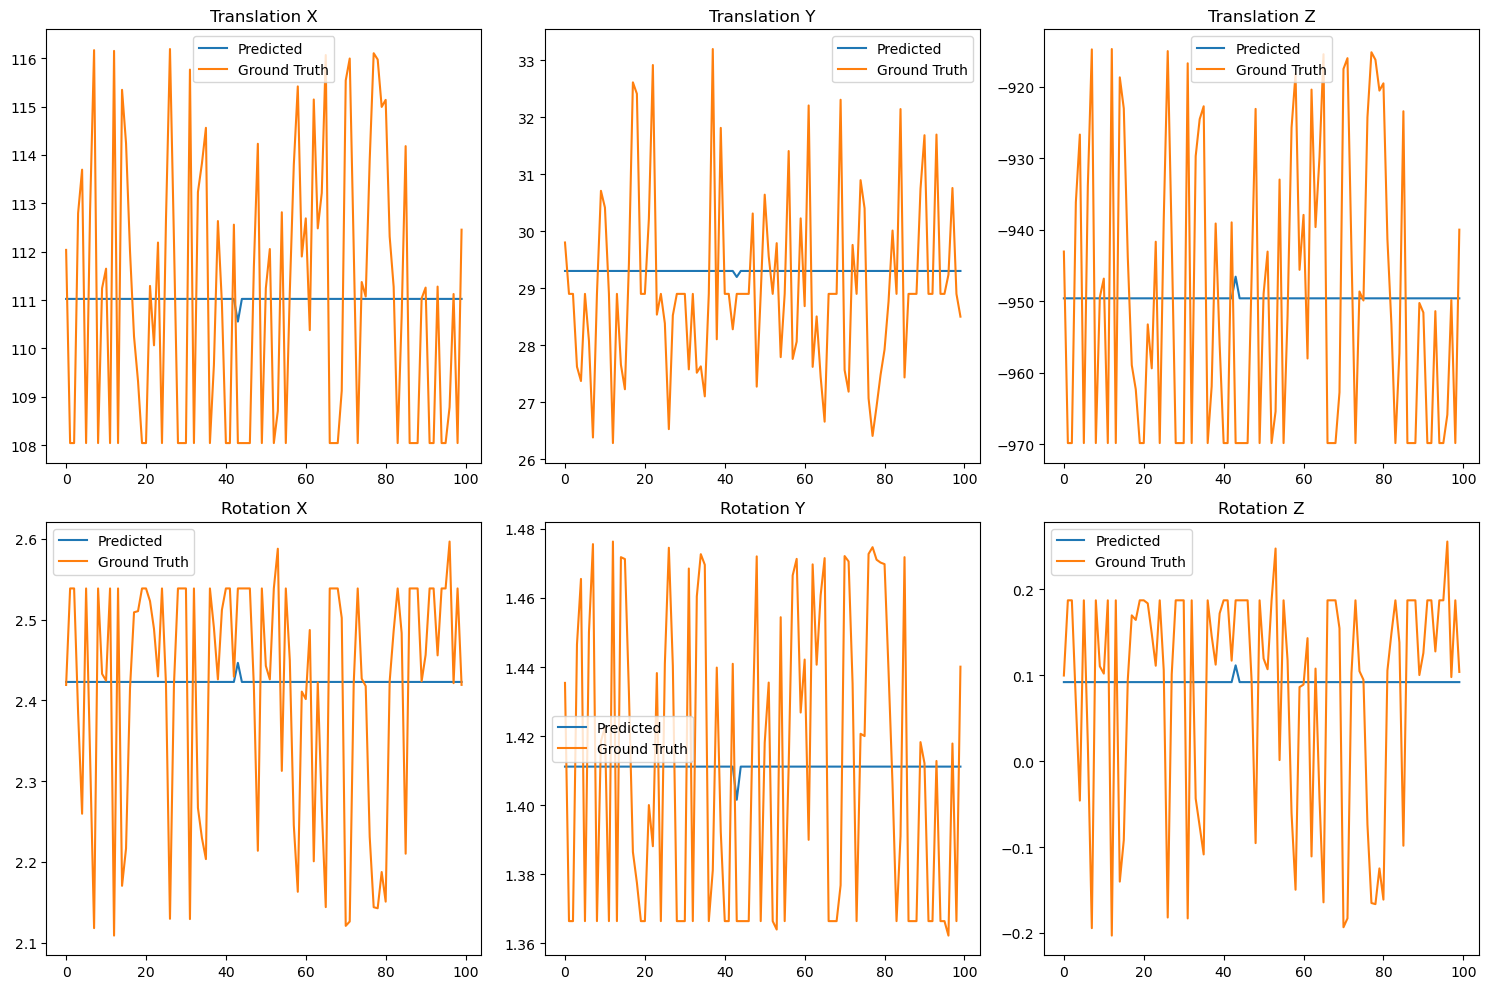

In [17]:
visualize_predictions(val_predictions, val_targets)

## 8. Generate ground truth volume


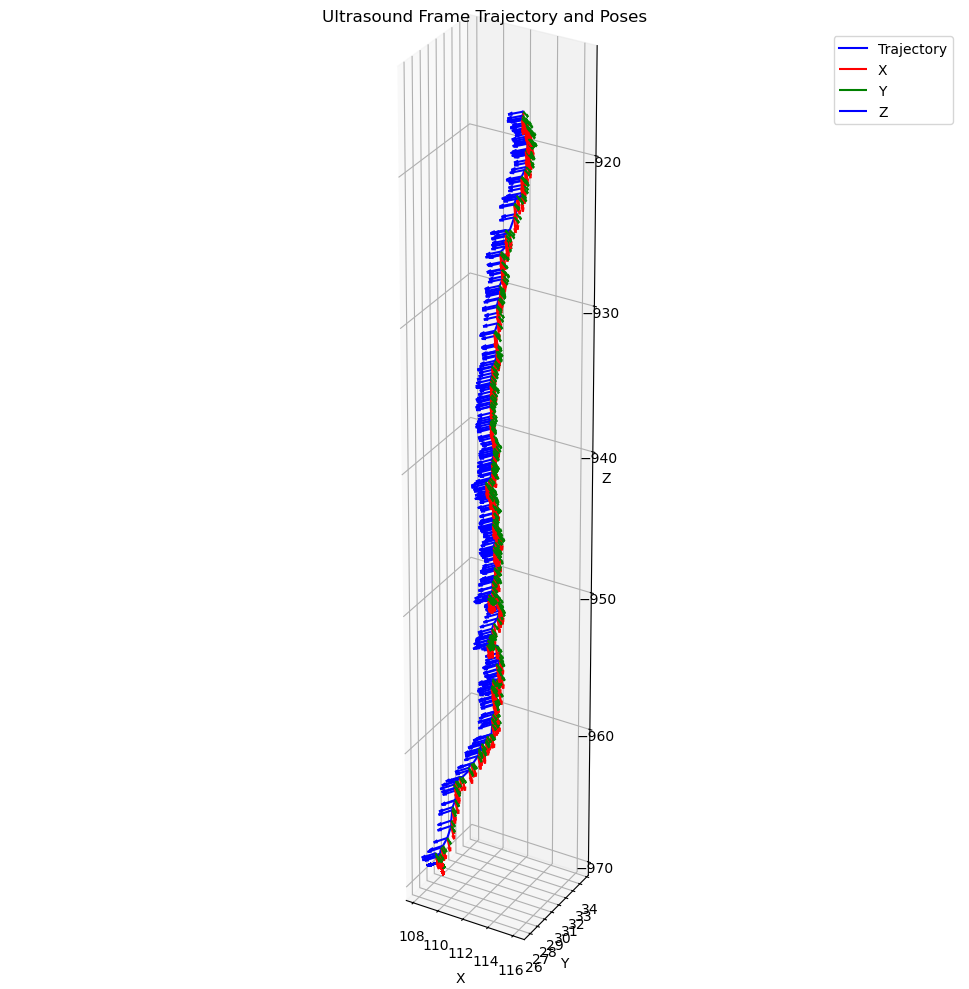

In [18]:
def plot_trajectory_and_poses(df, frame_stride=1, scale=10):
    # Extract optical tracker data
    positions = df[["ot_pos_x", "ot_pos_y", "ot_pos_z"]].values
    orientations = df[["ot_qw", "ot_qx", "ot_qy", "ot_qz"]].values

    # Create figure and 3D axis
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection="3d")

    # Plot trajectory
    ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], "b-", label="Trajectory")

    # Plot pose vectors
    for i in range(0, len(df), frame_stride):
        pos = positions[i]
        quat = orientations[i]

        # Convert quaternion to rotation matrix
        rot_matrix = Rotation.from_quat(quat).as_matrix()

        # Define coordinate axes
        axes = np.array([[scale, 0, 0], [0, scale, 0], [0, 0, scale]])

        # Rotate and translate axes
        transformed_axes = rot_matrix @ axes.T + pos[:, np.newaxis]

        # Plot coordinate axes
        colors = ["r", "g", "b"]
        labels = ["X", "Y", "Z"]
        for j, (color, label) in enumerate(zip(colors, labels)):
            if i == 0:  # Only add label for the first iteration
                ax.quiver(
                    pos[0],
                    pos[1],
                    pos[2],
                    transformed_axes[0, j] - pos[0],
                    transformed_axes[1, j] - pos[1],
                    transformed_axes[2, j] - pos[2],
                    color=color,
                    label=label,
                )
            else:
                ax.quiver(
                    pos[0],
                    pos[1],
                    pos[2],
                    transformed_axes[0, j] - pos[0],
                    transformed_axes[1, j] - pos[1],
                    transformed_axes[2, j] - pos[2],
                    color=color,
                )

    # Set labels and title
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Ultrasound Frame Trajectory and Poses")

    # Add legend
    ax.legend()

    # Set aspect ratio to 'equal'
    ax.set_box_aspect(
        (np.ptp(positions[:, 0]), np.ptp(positions[:, 1]), np.ptp(positions[:, 2]))
    )

    # Show plot
    plt.tight_layout()
    plt.show()


# Usage
# Assuming 'df' is your DataFrame containing the optical tracker data
plot_trajectory_and_poses(df, frame_stride=1, scale=1)

In [20]:
def reconstruct_ground_truth_volume(df, probe_specs, voxel_size=0.5):
    frames = df["frame"].values
    positions = df[["ot_pos_x", "ot_pos_y", "ot_pos_z"]].values
    orientations = df[["ot_qw", "ot_qx", "ot_qy", "ot_qz"]].values

    # Probe specifications
    depth = probe_specs["depth"]  # mm (axial direction)
    width = probe_specs["width"]  # mm (lateral direction)
    axial_res = probe_specs["axial_res"]  # mm
    lateral_res = probe_specs["lateral_res"]  # mm
    slice_thickness = probe_specs["slice_thickness"]  # mm (elevational direction)
    marker_to_probe_bottom = probe_specs["marker_to_probe_bottom"]  # mm

    # Calculate scaling factors
    axial_scale = depth / 1000  # mm per pixel in axial direction
    lateral_scale = width / 657  # mm per pixel in lateral direction

    # Calculate volume bounds
    rotations = Rotation.from_quat(orientations[:, [1, 2, 3, 0]])

    # Define frame corners in probe coordinates (y: axial, x: lateral, z: elevational)
    frame_corners = np.array(
        [[0, 0, 0], [width, 0, 0], [0, depth, 0], [width, depth, 0]]
    )

    # Transform to align with optical tracker coordinates
    transform_matrix = np.array(
        [
            [0, 0, -1],  # Tracker X -> -Probe Z (elevational)
            [1, 0, 0],  # Tracker Y -> Probe X (lateral)
            [0, -1, 0],  # Tracker Z -> -Probe Y (axial)
        ]
    )

    frame_corners = frame_corners @ transform_matrix.T

    # Add offset for marker to probe bottom
    frame_corners[:, 2] += marker_to_probe_bottom

    all_corners = (
        np.einsum("ijk,lk->ilj", rotations.as_matrix(), frame_corners)
        + positions[:, np.newaxis, :]
    )
    min_corner = np.min(all_corners.reshape(-1, 3), axis=0)
    max_corner = np.max(all_corners.reshape(-1, 3), axis=0)

    # Initialize volume
    volume_shape = np.ceil((max_corner - min_corner) / voxel_size).astype(int) + 1
    volume = np.zeros(volume_shape, dtype=np.float32)
    counts = np.zeros(volume_shape, dtype=np.int32)

    # Create coordinate grid for frames
    x, y = np.meshgrid(np.arange(657) * lateral_scale, np.arange(1000) * axial_scale)
    frame_coords = np.stack((x, y, np.zeros_like(x)), axis=-1)

    # Transform frame coordinates to align with optical tracker
    frame_coords = frame_coords @ transform_matrix.T
    frame_coords[:, :, 2] += marker_to_probe_bottom

    print("Reconstructing ground truth volume...")
    for i, (frame, position, orientation) in enumerate(
        tqdm(zip(frames, positions, orientations), total=len(frames))
    ):
        # Convert frame to grayscale
        frame = np.mean(frame, axis=-1).astype(np.float32)

        # Transform frame coordinates to world space
        rotation = Rotation.from_quat(orientation[[1, 2, 3, 0]]).as_matrix()
        world_coords = np.einsum("ij,klj->kli", rotation, frame_coords) + position

        # Calculate voxel coordinates
        voxel_coords = np.round((world_coords - min_corner) / voxel_size).astype(int)

        # Filter out-of-bounds voxels
        mask = np.all((voxel_coords >= 0) & (voxel_coords < volume_shape), axis=2)
        valid_voxels = voxel_coords[mask]
        valid_intensities = frame[mask]

        # Update volume and counts
        np.add.at(volume, tuple(valid_voxels.T), valid_intensities)
        np.add.at(counts, tuple(valid_voxels.T), 1)

    # Average intensities and handle zero counts
    mask = counts > 0
    volume[mask] /= counts[mask]

    return volume, min_corner, voxel_size


# Probe specifications
probe_specs = {
    "depth": 50,  # mm (axial direction)
    "width": 38,  # mm (lateral direction, assuming 19 mm on each side of the center)
    "axial_res": 0.5,  # mm
    "lateral_res": 2,  # mm
    "slice_thickness": 5,  # mm (elevational direction)
    "marker_to_probe_bottom": 54,  # mm (approximate, to be refined)
}

# Reconstruct ground truth volume
ground_truth_volume, volume_origin, voxel_size = reconstruct_ground_truth_volume(
    df, probe_specs, voxel_size=0.1  # lower voxel size corresponds to higher resolution
)

print(f"Ground truth volume shape: {ground_truth_volume.shape}")
print(f"Volume origin: {volume_origin}")
print(f"Voxel size: {voxel_size} mm")

Reconstructing ground truth volume...


  0%|          | 0/500 [00:00<?, ?it/s]

Ground truth volume shape: (697, 715, 601)
Volume origin: [  44.0769405   -13.89386663 -969.06145428]
Voxel size: 0.1 mm


In [21]:
# Save the ground truth volume
np.save("ground_truth_volume2.npy", np.flip(ground_truth_volume, axis=0))
print("Ground truth volume saved as 'ground_truth_volume2.npy'")

# Save metadata
metadata = {
    "volume_origin": volume_origin.tolist(),
    "voxel_size": voxel_size,
    "probe_specs": probe_specs,
}
np.save("ground_truth_volume_metadata2.npy", metadata)
print("Metadata saved as 'ground_truth_volume_metadata2.npy'")

Ground truth volume saved as 'ground_truth_volume2.npy'
Metadata saved as 'ground_truth_volume_metadata2.npy'


In [22]:
ground_truth_volume.shape

(697, 715, 601)

## Reconstruct predictions


In [23]:
def euler_to_rotation_matrix(euler_angles):
    return Rotation.from_euler("xyz", euler_angles).as_matrix()


def reconstruct_predicted_volume(
    frames, predicted_transforms, probe_specs, voxel_size=0.5
):
    # Extract translations and rotations from predicted transforms
    translations = predicted_transforms[:, :3]
    rotations = [
        euler_to_rotation_matrix(euler) for euler in predicted_transforms[:, 3:]
    ]

    # Probe specifications
    depth = probe_specs["depth"]
    width = probe_specs["width"]
    marker_to_probe_bottom = probe_specs["marker_to_probe_bottom"]

    # Calculate scaling factors
    axial_scale = depth / frames.shape[1]
    lateral_scale = width / frames.shape[2]

    # Calculate volume bounds
    frame_corners = np.array(
        [[0, 0, 0], [width, 0, 0], [0, depth, 0], [width, depth, 0]]
    )
    transform_matrix = np.array(
        [
            [0, 0, -1],
            [1, 0, 0],
            [0, -1, 0],
        ]
    )
    frame_corners = frame_corners @ transform_matrix.T
    frame_corners[:, 2] += marker_to_probe_bottom

    all_corners = (
        np.einsum("ijk,lk->ilj", rotations, frame_corners)
        + translations[:, np.newaxis, :]
    )
    min_corner = np.min(all_corners.reshape(-1, 3), axis=0)
    max_corner = np.max(all_corners.reshape(-1, 3), axis=0)

    # Initialize volume
    volume_shape = np.ceil((max_corner - min_corner) / voxel_size).astype(int) + 1
    volume = np.zeros(volume_shape, dtype=np.float32)
    counts = np.zeros(volume_shape, dtype=np.int32)

    # Create coordinate grid for frames
    x, y = np.meshgrid(
        np.arange(frames.shape[2]) * lateral_scale,
        np.arange(frames.shape[1]) * axial_scale,
    )
    frame_coords = np.stack((x, y, np.zeros_like(x)), axis=-1)
    frame_coords = frame_coords @ transform_matrix.T
    frame_coords[:, :, 2] += marker_to_probe_bottom

    print("Reconstructing predicted volume...")
    for i, (frame, translation, rotation) in enumerate(
        tqdm(zip(frames, translations, rotations), total=len(frames))
    ):
        # Ensure frame is 2D (height x width)
        if frame.ndim == 3:
            frame = np.mean(frame, axis=-1).astype(np.float32)

        # Transform frame coordinates to world space
        world_coords = np.einsum("ij,klj->kli", rotation, frame_coords) + translation

        # Calculate voxel coordinates
        voxel_coords = np.round((world_coords - min_corner) / voxel_size).astype(int)

        # Filter out-of-bounds voxels
        mask = np.all((voxel_coords >= 0) & (voxel_coords < volume_shape), axis=2)
        valid_voxels = voxel_coords[mask]
        valid_intensities = frame[mask]

        # Update volume and counts
        np.add.at(volume, tuple(valid_voxels.T), valid_intensities)
        np.add.at(counts, tuple(valid_voxels.T), 1)

    # Average intensities and handle zero counts
    mask = counts > 0
    volume[mask] /= counts[mask]

    return volume, min_corner, voxel_size

In [24]:
# Assuming you have already trained the model and have the validation dataset
model.eval()
all_frames = []
all_predictions = []

with torch.no_grad():
    for frames, imu_data, _ in val_loader:
        frames = frames.to(device)
        imu_data = imu_data.to(device)
        outputs = model(frames, imu_data)

        all_frames.append(frames.cpu().numpy())
        all_predictions.append(outputs.cpu().numpy())

all_frames = np.concatenate(all_frames, axis=0)
all_predictions = np.concatenate(all_predictions, axis=0)

# Reconstruct the predicted volume
predicted_volume, volume_origin, voxel_size = reconstruct_predicted_volume(
    all_frames[:, 0],  # Use only the first frame of each sequence
    all_predictions,  # Use all predictions
    probe_specs,
    voxel_size=0.1,
)

print(f"Predicted volume shape: {predicted_volume.shape}")
print(f"Volume origin: {volume_origin}")
print(f"Voxel size: {voxel_size} mm")

# Save the predicted volume
np.save("predicted_volume.npy", predicted_volume)
print("Predicted volume saved as 'predicted_volume.npy'")

# Save metadata
metadata = {
    "volume_origin": volume_origin.tolist(),
    "voxel_size": voxel_size,
    "probe_specs": probe_specs,
}
np.save("predicted_volume_metadata.npy", metadata)
print("Metadata saved as 'predicted_volume_metadata.npy'")

Reconstructing predicted volume...


  0%|          | 0/100 [00:00<?, ?it/s]

Predicted volume shape: (619, 626, 132)
Volume origin: [  73.77915046  -36.05526916 -956.07145139]
Voxel size: 0.1 mm
Predicted volume saved as 'predicted_volume.npy'
Metadata saved as 'predicted_volume_metadata.npy'


In [26]:
def preprocess_and_align_data(df):
    # Extract IMU and OT data
    imu_acc = df[["imu_acc_x", "imu_acc_y", "imu_acc_z"]].values
    imu_orientation = df[
        ["imu_orientation_x", "imu_orientation_y", "imu_orientation_z"]
    ].values
    ot_pos = df[["ot_pos_x", "ot_pos_y", "ot_pos_z"]].values
    ot_quat = df[["ot_qw", "ot_qx", "ot_qy", "ot_qz"]].values

    # 1. Handle IMU acceleration
    # We'll keep accelerations as they are, since they're already rates of change
    # But we'll transform them to the world frame using IMU orientations
    imu_rotations = Rotation.from_euler("xyz", imu_orientation)
    world_acc = imu_rotations.apply(imu_acc)

    # 2. Calculate OT velocities (as an analog to accelerations)
    ot_vel = np.diff(ot_pos, axis=0, prepend=ot_pos[0][np.newaxis, :])

    # 3. Align IMU and OT trajectories using PCA
    # Combine world_acc and ot_vel for PCA
    combined_data = np.hstack((world_acc, ot_vel))
    pca = PCA(n_components=3)
    pca.fit(combined_data)

    # Transform both datasets to the PCA space
    world_acc_pca = pca.transform(world_acc)
    ot_vel_pca = pca.transform(ot_vel)

    # 4. Find the rotation between PCA space and OT space
    ot_rotations = Rotation.from_quat(ot_quat)
    pca_to_ot_rotation = Rotation.align_vectors(ot_vel, ot_vel_pca)[0]

    # 5. Transform IMU data to OT space
    aligned_imu_acc = pca_to_ot_rotation.apply(world_acc_pca)

    # 6. Calculate relative rotations for OT data
    ot_rel_rotations = ot_rotations[:-1].inv() * ot_rotations[1:]
    ot_rel_quats = ot_rel_rotations.as_quat()

    # Prepare the preprocessed dataframe
    preprocessed_df = pd.DataFrame(
        {
            "aligned_imu_acc_x": aligned_imu_acc[:, 0],
            "aligned_imu_acc_y": aligned_imu_acc[:, 1],
            "aligned_imu_acc_z": aligned_imu_acc[:, 2],
            "imu_orientation_x": imu_orientation[:, 0],
            "imu_orientation_y": imu_orientation[:, 1],
            "imu_orientation_z": imu_orientation[:, 2],
            "ot_vel_x": ot_vel[:, 0],
            "ot_vel_y": ot_vel[:, 1],
            "ot_vel_z": ot_vel[:, 2],
        }
    )

    # Add relative rotation quaternions
    for i in range(4):
        preprocessed_df[f"ot_rel_quat_{i}"] = np.pad(
            ot_rel_quats[:, i], (0, 1), mode="edge"
        )

    # Add original frame data
    preprocessed_df["frame"] = df["frame"]

    return preprocessed_df, pca_to_ot_rotation

In [27]:
import pandas as pd

pd.read_hdf("/home/varun/xia_lab/repos/ABUSFusion/scans/20240826/wrist_data.h5").head()

,timestamp,frame,imu_acc_x,imu_acc_y,imu_acc_z,imu_orientation_x,imu_orientation_y,imu_orientation_z,ot_pos_x,ot_pos_y,ot_pos_z,ot_qw,ot_qx,ot_qy,ot_qz
0,2024-08-14 14:04:53.612948,"[[[35, 38, 38], [41, 44, 44], [54, 57, 57], [5...",0.00518,-0.002743,-0.098182,-0.034068,0.040456,0.043649,108.045212,28.900089,-969.858948,0.719787,0.255863,-0.57866,0.285646
1,2024-08-14 14:04:53.712948,"[[[35, 38, 38], [41, 44, 44], [54, 57, 57], [5...",0.00518,-0.002743,-0.098182,-0.034068,0.040456,0.043649,108.045212,28.900089,-969.858948,0.719787,0.255863,-0.57866,0.285646
2,2024-08-14 14:04:53.812948,"[[[35, 38, 38], [41, 44, 44], [54, 57, 57], [5...",0.00518,-0.002743,-0.098182,-0.034068,0.040456,0.043649,108.045212,28.900089,-969.858948,0.719787,0.255863,-0.57866,0.285646
3,2024-08-14 14:04:53.912948,"[[[41, 44, 44], [49, 52, 52], [61, 64, 64], [6...",0.00518,-0.002743,-0.098182,-0.034068,0.040456,0.043649,108.045212,28.900089,-969.858948,0.719787,0.255863,-0.57866,0.285646
4,2024-08-14 14:04:54.012948,"[[[42, 45, 45], [49, 52, 52], [61, 64, 64], [6...",0.00518,-0.002743,-0.098182,-0.034068,0.040456,0.043649,108.045212,28.900089,-969.858948,0.719787,0.255863,-0.57866,0.285646


In [28]:
df["frame"].values.shape, df["frame"].values[0].shape

((500,), (1000, 657, 3))